**Importing the necessary libraries**

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

**Preparing the dataset**

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/chest_xray.zip" -d /content/chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inf

**Split the dataset into train and valid**

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
input_folder="/content/chest_xray/chest_xray/train"
output="/content/chest_xray/chest_xray/"
splitfolders.ratio(input_folder, output="output", seed=1337, ratio=(.8,.2), group_prefix=None)


Copying files: 5232 files [00:25, 204.08 files/s]


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/output/train/'
valid_path = '/content/output/val/'

In [ ]:
# Import the ResNet50 library as shown below and add preprocessing layer
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/output/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:

# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)
valid_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/output/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 4185 images belonging to 2 classes.


In [ ]:
val_set = valid_datagen.flow_from_directory('/content/output/val/',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 1047 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/chest_xray/chest_xray/test/',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


**Training the model (Transfer Learning)**

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/15
262/262 [==============================] - 150s 448ms/step - loss: 0.5409 - accuracy: 0.8065 - val_loss: 0.3182 - val_accuracy: 0.8797
Epoch 2/15
262/262 [==============================] - 116s 441ms/step - loss: 0.4952 - accuracy: 0.8332 - val_loss: 1.1386 - val_accuracy: 0.6543
Epoch 3/15
262/262 [==============================] - 116s 441ms/step - loss: 0.5449 - accuracy: 0.8526 - val_loss: 0.1760 - val_accuracy: 0.9312
Epoch 4/15
262/262 [==============================] - 115s 439ms/step - loss: 0.5017 - accuracy: 0.8698 - val_loss: 0.1962 - val_accuracy: 0.9284
Epoch 5/15
262/262 [==============================] - 116s 441ms/step - loss: 0.2990 - accuracy: 0.8980 - val_loss: 0.1493 - val_accuracy: 0.9389
Epoch 6/15
262/262 [==============================] - 115s 438ms/step - loss: 0.4173 - accuracy: 0.8843 - val_loss: 0.3168 - val_accuracy: 0.8825
Epoch 7/15
262/262 [==============================] - 115s 440ms/step - loss: 0.4387 - accuracy: 0.8722 - val_loss: 0.3094 -

**Evaluating the model**

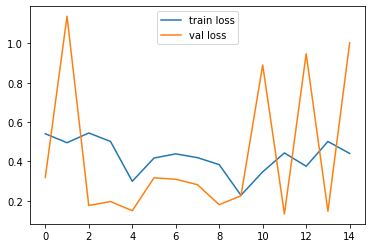

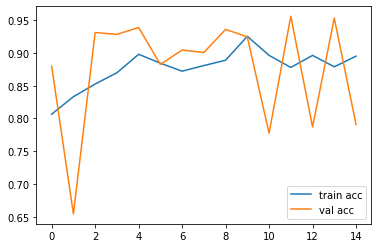

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plot the loss

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

**Save the model**

In [ ]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model.save('model_XrayImg_resnet50.h5') 
!cp /content/model_XrayImg_resnet50.h5 /content/drive/MyDrive/ #saving on drive

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


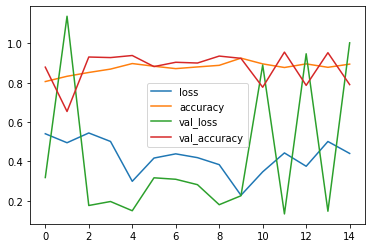

In [ ]:
import pandas as pd

pd.DataFrame(model.history.history).plot()

 **Making predictions**

In [ ]:

y_pred = model.predict(test_set, verbose=1)

39/39 [==============================] - 10s 232ms/step


In [ ]:
test_accu = model.evaluate(test_set)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 8s 209ms/step - loss: 0.6521 - accuracy: 0.8109
The testing accuracy is : 81.08974099159241 %


In [ ]:
preds = model.predict(test_set,verbose=1)

39/39 [==============================] - 8s 209ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_accu, preds)

ValueError: ignored

In [ ]:
cm = pd.DataFrame(data=confusion_matrix(test_set.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

NameError: ignored

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))